In [8]:
from copy import deepcopy

from glob import glob
from typing import List, Tuple, Optional, Callable, Mapping, Any
from tqdm.notebook import tqdm

import pandas as pd
import numpy as np
import cv2
import skfuzzy as fuzz

from sklearn.cluster import KMeans, DBSCAN, OPTICS, SpectralClustering, MeanShift
from sklearn.metrics import pairwise_distances
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from skimage.segmentation import flood_fill
from scipy import ndimage
from matplotlib import pyplot as plt 

%matplotlib inline

## Read Data

In [2]:
def read_one_image(
    image_name: str,
    resize_shape: Optional[Tuple[int, int]] = None
):
    image = cv2.imread(image_name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if resize_shape is not None:
        image = cv2.resize(image, resize_shape)
    return image

def read_images(
    image_names: List[str],
    resize_shape: Optional[Tuple[int, int]] = None
):
    images = [read_one_image(el, resize_shape) for el in image_names]
    if resize_shape is not None:
        images = np.stack(images)
    return images

['data/2_животные (2).jpg', 'data/2_животные.jpg']


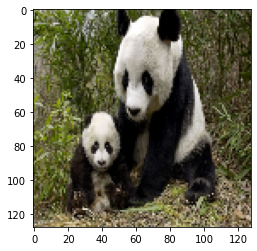

In [3]:
filenames = glob('data/2*.jpg')
print(filenames)

all_images = read_images(filenames, (128,128))
plt.imshow(all_images[0]);

## Util functions

In [4]:
def uniform_normalize(im: np.array):
    return im.astype(float) / 255.0

def add_coord_encoding(im: np.array):
    x_encode = np.linspace(0,1,im.shape[0])
    x_encode = x_encode[:,None,None]
    x_encode = np.repeat(x_encode, im.shape[1], axis=1)
    
    y_encode = np.linspace(0,1,im.shape[1])
    y_encode = y_encode[None,:,None]
    y_encode = np.repeat(y_encode, im.shape[0], axis=0)
        
    return np.concatenate([im, x_encode, y_encode], axis=-1)

def apply_cluster_function(
    im: np.array,
    clust_f: Callable,
    use_coord_enc: bool = False,
    use_uniform_norm: bool = False
):
    if use_uniform_norm:
        im = uniform_normalize(im)
    if use_coord_enc:
        im = add_coord_encoding(im)
    mask = clust_f(im)
    return mask

def hi_beni_criteria(
    im: np.array,
    mask: np.array,
    
):
    nominator = 0.0
    denominator = 0.0
    im = uniform_normalize(im)
    clusters = np.unique(mask)
    
    im = im.reshape(-1,im.shape[-1])
    mask = mask.flatten()
    for clust in tqdm(clusters):
        clust_elems = im[mask == clust]
        non_clust_elems = im[mask != clust]
        nominator += pairwise_distances(clust_elems, n_jobs=-1).sum()
        denominator += pairwise_distances(clust_elems, non_clust_elems, n_jobs=-1).sum()
    return nominator / denominator

def fuzzy_kmeans(
    im: np.array, 
    params: Mapping[str, Any]
):
    return_classes = params.pop('return_classes')
    
    initial_shape = (im.shape[0], im.shape[1]) 
    im = im.reshape(-1,im.shape[-1]).T
    fuzz_clusters = fuzz.cmeans(
        data=im,
        **params
    )[1]
    fuzz_clusters = fuzz_clusters.T.reshape(initial_shape[0], initial_shape[1], params['c'])
    
    if return_classes:
        fuzz_clusters = fuzz_clusters.argmax(-1)
        
    return fuzz_clusters

def apply_watershed(
    input_im: np.ndarray
):
    gray = cv2.cvtColor(deepcopy(input_im), cv2.COLOR_RGB2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    # Compute Euclidean distance from every binary pixel
    # to the nearest zero pixel then find peaks
    distance_map = ndimage.distance_transform_edt(thresh)
    local_max = peak_local_max(distance_map, indices=False, min_distance=20, labels=thresh)

    # Perform connected component analysis then apply Watershed
    markers = ndimage.label(local_max, structure=np.ones((3, 3)))[0]
    labels = watershed(-distance_map, markers, mask=thresh)  
    
    return labels

def apply_grabcut(
    input_image: np.ndarray,
    inital_box: Tuple[int,int,int,int]
):
    # Plot bound mask
    bound_mask = deepcopy(input_image)
    bound_mask = cv2.rectangle(bound_mask, (inital_box[0], inital_box[1]),(inital_box[2], inital_box[3]), [255,0,0], 1) 
    
    plt.imshow(bound_mask)
    plt.show()
    
    # Plot GrabCut
    temp_im = deepcopy(input_image)
    mask = np.zeros(temp_im.shape[:2],np.uint8)
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
    rect = (0,0,120,120)
    cv2.grabCut(temp_im,mask,inital_box,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    
    plt.imshow(temp_im * mask2[:,:,None])
    plt.show()
    
    # Count HiBeni
    score = hi_beni_criteria(input_image, mask2)
    
    return score

def apply_flood_fill(
    input_image: np.ndarray,
    inital_point: Tuple[int,int],
    toler: int = 50
):
    grayscale = cv2.cvtColor(input_image, cv2.COLOR_RGB2GRAY)
    segmented = flood_fill(grayscale, inital_point, 255, tolerance=toler)
    segmented = (segmented == 255).astype('uint8')
    
    plt.imshow((input_image * segmented[:,:,None]).astype('uint8'))
    plt.show()
    plt.imshow(segmented)
    plt.show()
    
    # Count HiBeni
    score = hi_beni_criteria(input_image, segmented)
    
    return score

def cv2_kmeans(
    im: np.array,
    params: Mapping[str, Any] 
):
    initial_shape = (im.shape[0], im.shape[1])
    im = im.reshape(-1,im.shape[-1])
    
    # Define criteria = ( type, max_iter = 10 , epsilon = 1.0 )
    criteria = (
        cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 
        params['max_iter'], 
        params['epsilon']
    )
    # Set flags (Just to avoid line break in the code)
    flags = cv2.KMEANS_RANDOM_CENTERS
    # Apply KMeans
    _,labels,_ = cv2.kmeans(
        im.astype(np.float32),
        params['n_clusters'],None,criteria,params['n_attempts'],flags
    )
    
    labels = labels[:,0].reshape(*initial_shape)
    return labels

def sklearn_algs(
    im: np.array,
    algorithm: object,
    params: Mapping[str, Any]
):
    initial_shape = (im.shape[0], im.shape[1])
    im = im.reshape(-1,im.shape[-1]).astype(float)
    clusters = algorithm(**params).fit_predict(im)
    clusters = clusters.reshape(*initial_shape)
    return clusters

def cluster_evaluate_all_images(
    ims: np.array,
    clust_f: Callable,
    use_coord_enc: bool = False,
    use_normalization: bool = False,
    metric_fns: List[Tuple[Callable, str]] = [(hi_beni_criteria, 'hi-beni')]
):
    scores = {m_k:[] for _, m_k in metric_fns}
    for i in tqdm(range(ims.shape[0])):
        im = ims[i]
        
        plt.title("Image")
        plt.imshow(im)
        plt.show()
        
        mask = apply_cluster_function(
                    im=im,
                    clust_f=clust_f,
                    use_coord_enc=use_coord_enc,
                    use_uniform_norm=use_normalization
                )
        
        
        for clust in np.unique(mask):
            plt.title(f"Cluster {clust}")
            plt.imshow(im * (mask[:,:,None] == clust))
            plt.show()
           
        for m_f, m_k in metric_fns:
            m_v = m_f(im, mask)
            scores[m_k].append(m_v)
            print(f"{m_k} : {m_v}")
      
    for m_f, m_k in metric_fns:
        print(f"Mean {m_k} : {np.mean(scores[m_k])}")
        print(f"Std {m_k} : {np.std(scores[m_k])}")
    
    return scores

In [5]:
all_results = dict()

## Flood Fill

In [6]:
all_results['flood_fill'] = {"hi-beni": []}

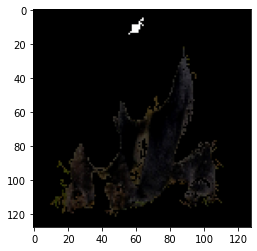

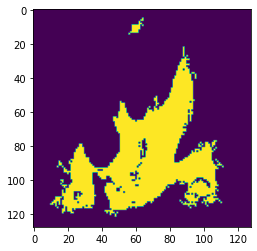

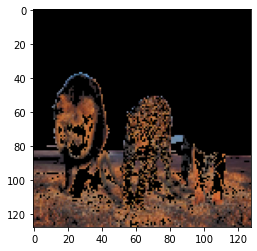

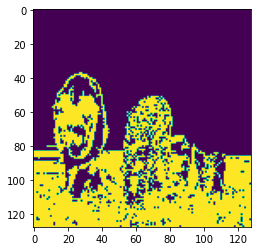

In [9]:
all_results['flood_fill']['hi-beni'].append(apply_flood_fill(all_images[0], (80,80)))
all_results['flood_fill']['hi-beni'].append(apply_flood_fill(all_images[1], (80,80)))

## Watershed

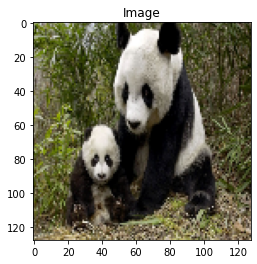

/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


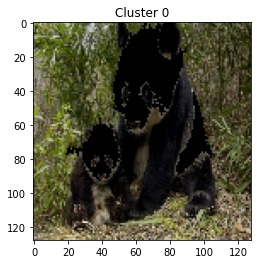

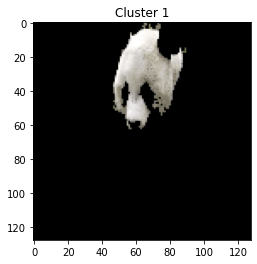

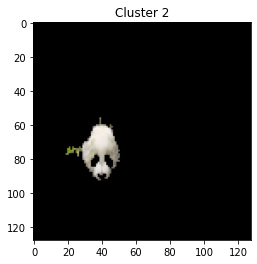

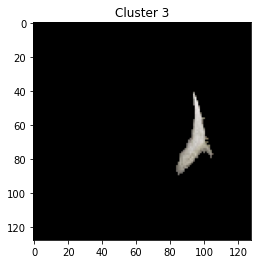


hi-beni : 1.3681247424034224


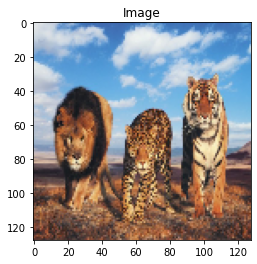

/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


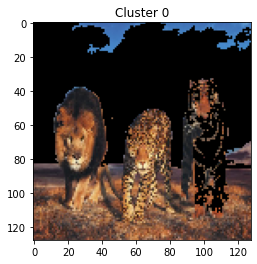

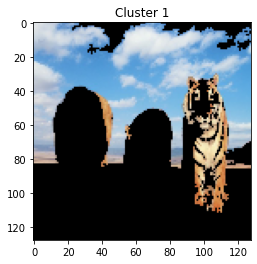


hi-beni : 0.4712105726162967

Mean hi-beni : 0.9196676575098596
Std hi-beni : 0.44845708489356284


In [11]:
all_results['watershed'] = cluster_evaluate_all_images(
    ims=all_images,
    clust_f=lambda x: apply_watershed(x),
    use_coord_enc=False
)

## GrabCut

In [12]:
all_results['grabcut'] = {"hi-beni": []}

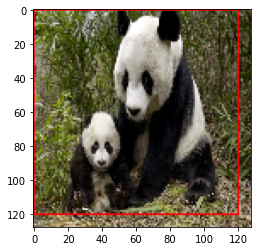

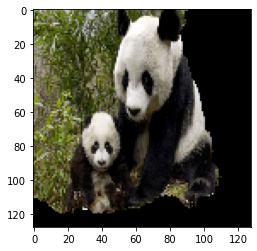

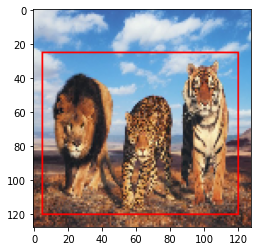

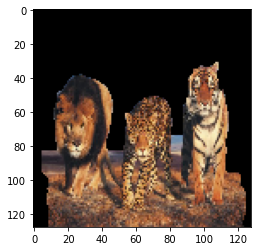

In [13]:
all_results['grabcut']['hi-beni'].append(apply_grabcut(all_images[0], (0,0,120,120)))
all_results['grabcut']['hi-beni'].append(apply_grabcut(all_images[1], (5,25,120,120)))

## Sklearn MeanShift

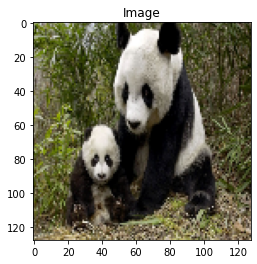

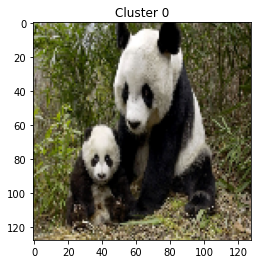


hi-beni : inf


/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars


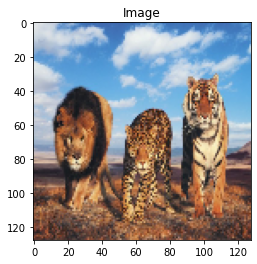

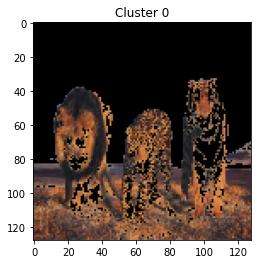

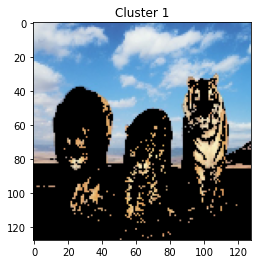


hi-beni : 0.41511081548320883

Mean hi-beni : inf
Std hi-beni : nan


/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/numpy/core/_methods.py:193: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [14]:
all_results['sklearn_meanshift'] = cluster_evaluate_all_images(
    ims=all_images,
    clust_f=lambda x: sklearn_algs(x, MeanShift, {}),
    use_normalization=False
)

## Result table

In [15]:
result_df = pd.DataFrame(
    index=all_results.keys(),
    columns=all_results[next(iter(all_results.keys()))].keys()
)

for k_exp in all_results.keys():
    for k_m in all_results[k_exp].keys():
        result_df.loc[k_exp,k_m] = all_results[k_exp][k_m]
        
for col in result_df.columns:
    result_df[f'{col}_mean'] = result_df[col].apply(np.mean)
    result_df[f'{col}_std'] = result_df[col].apply(np.std)

result_df

,hi-beni,hi-beni_mean,hi-beni_std
flood_fill,"[1.4378595003750332, 0.7544290275528371]",1.096144,0.341715
watershed,"[1.3681247424034224, 0.4712105726162967]",0.919668,0.448457
grabcut,"[1.4812433812196626, 0.5389902495263804]",1.010117,0.471127
sklearn_meanshift,"[inf, 0.41511081548320883]",inf,NaN
